# 03. Coarse Grained Simulations

Coarse-graining a box of 500 methanol molecules from the all atom simulation given in `CG_tutorial/meth.gsd` file.

In [1]:
import tensorflow as tf
# reduce logging
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd, gsd.hoomd, pickle
import matplotlib.pyplot as plt,matplotlib
%matplotlib inline

## Build the computational graph

Here we prepare the computations that will be executed at each step during the simulation. We have access to placeholders for the neighbor list, positions, types, box dimensions of the simulation.

This graph works in three steps:

1. Creaet a mapping matrix that describes how to group atoms together in a coarse-grained system given the all-atom system
2. Create a coarse-grained mapped trajectory, where atoms/forces are grouped together using the mapping matrix
3. Compute the radial distribution function of this new mapped trajectory
4. Compute the radial distribution function of the C-C from the all-atom sysetm for comparison

In [2]:
### Graph building code ###

def make_train_graph(NN, rcut, NN_aa, N_hidden, system):

    #mamximum number of neighbors=0, graph will not compute forces to use in TF
    graph = htf.SimModel(NN_aa, output_forces=False)
    assign_ops = []
    prints = []
    #get mapping from molecule index to particle index
    molecule_mapping = htf.find_molecules(system)

    for m in molecule_mapping:
        #ensure all molecules are of the same length
        assert len(m) == len(molecule_mapping[0])
    N = sum([len(m) for m in molecule_mapping])
    M = len(molecule_mapping)
    #number of atoms in a molecule=MN
    MN = len(molecule_mapping[0])
    # create one bead mapping. mapping matrices must be created for other types of mappings
    molecule_mapping_matrix = np.ones([1, MN], dtype=np.int)
    #create a mass-weighted M x N mapping operator 
    cg_mapping = htf.sparse_mapping([molecule_mapping_matrix for _ in molecule_mapping], 
                                    molecule_mapping, system=system)
    assert cg_mapping.shape == (M, N)
    #calculate the center of mass of a CG bead
    mapped_pos = htf.center_of_mass(graph.positions[:,:3], cg_mapping, graph.box_size, name='com-mapped-positions')
    #create the mapped neighbot list
    mapped_nlist = htf.compute_nlist(mapped_pos, rcut, NN, graph.box_size)
    #create a non mass-weighted M x N mapping operator
    force_cg_mapping = htf.sparse_mapping([molecule_mapping_matrix for _ in molecule_mapping], molecule_mapping)
    #calculate the coarse grained forces
    mapped_force = tf.sparse.matmul(force_cg_mapping, graph.forces, name='mapped-forces')
    #compute RDF for mapped and C-C in all-atom
    rdf = graph.compute_rdf([0.1,rcut], 'rdf', nbins=200, nlist=mapped_nlist)
    aa_rdf = graph.compute_rdf([0.1,rcut], 'aa-rdf', nbins=200, type_i=3, type_j=3)
    graph.running_mean(rdf,'avg-rdf') 
    graph.running_mean(aa_rdf,'avg-aa-rdf') 
    #save the graph
    graph.save('CG_tutorial/cg_model')

## Running the simulation

Here we begin a simulation of methanol. This code is a little complex, but not really about hoomd-tf. This is the details of setting-up the force field to simulate methanol (e.g., treating electrostatics, dispersion, thermostat). 

In [3]:
### Hoomd-Sim code ###

g = gsd.hoomd.open('CG_tutorial/meth.gsd')
c = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename='CG_tutorial/meth.gsd')
c.sorter.disable()
set_rcut=10.0

#call the graph building code
make_train_graph(128,10.0,256,48, system)

with htf.tfcompute('CG_tutorial/cg_model', device='/CPU:0') as tfcompute:
    nlist = hoomd.md.nlist.cell()

    #set-up pppm
    charged = hoomd.group.all()
    pppm = hoomd.md.charge.pppm(nlist=nlist, group=charged)
    pppm.set_params(Nx=32, Ny=32, Nz=32, order=6, rcut=set_rcut)

    #set-up pair coefficients
    nlist.reset_exclusions(['1-2', '1-3', '1-4','body'])
    lj = hoomd.md.pair.force_shifted_lj(r_cut=set_rcut, nlist=nlist)
    forces = [lj]
    lj.pair_coeff.set("opls_156", "opls_156", sigma=2.5, epsilon=0.03)
    lj.pair_coeff.set("opls_156", "opls_157", sigma=2.96, epsilon=0.05)
    lj.pair_coeff.set("opls_156", "opls_154", sigma=2.79, epsilon=0.07)
    lj.pair_coeff.set("opls_156", "opls_155", sigma=5.0, epsilon=0.0)
    lj.pair_coeff.set("opls_157", "opls_157", sigma=3.5, epsilon=0.07)
    lj.pair_coeff.set("opls_157", "opls_154", sigma=3.31, epsilon=0.11)
    lj.pair_coeff.set("opls_157", "opls_155", sigma=5.92, epsilon=0.0)
    lj.pair_coeff.set("opls_154", "opls_154", sigma=3.12, epsilon=0.17)
    lj.pair_coeff.set("opls_154", "opls_155", sigma=5.59, epsilon=0.0)
    lj.pair_coeff.set("opls_155", "opls_155", sigma=10.0, epsilon=0.0)

    #set-up bonds
    harmonic = hoomd.md.bond.harmonic()
    harmonic.bond_coeff.set("opls_156-opls_157", k=340.00, r0=1.09)
    harmonic.bond_coeff.set("opls_154-opls_157", k=320.00, r0=1.41)
    harmonic.bond_coeff.set("opls_154-opls_155", k=553.00, r0=0.95)

    #set-up angles
    harm_angle = hoomd.md.angle.harmonic()
    harm_angle.angle_coeff.set("opls_154-opls_157-opls_156", k=70.0, t0=1.90)
    harm_angle.angle_coeff.set("opls_155-opls_154-opls_157", k=110.0, t0=1.89)
    harm_angle.angle_coeff.set("opls_156-opls_157-opls_156", k=66.0, t0=1.88)

    #set-up dihedrals
    dihedral = hoomd.md.dihedral.opls()
    dihedral.dihedral_coeff.set("opls_155-opls_154-opls_157-opls_156", k1=0.0, k2=0.0, k3=0.45, k4=0.0)

    group_all = hoomd.group.all()
    kT = 1.9872/1000

    #NVT Simulation in Hoomd
    im = hoomd.md.integrate.mode_standard(dt=5.0/489.0)
    nvt = hoomd.md.integrate.nvt(group=group_all, kT=298.15 * kT, tau=350 / 48.9)
    nvt.randomize_velocities(1234)

    #equilibrate
    hoomd.run(200)

    #communicate positions, neighbor list and forces to TensorFlow model
    tfcompute.attach(nlist, r_cut=set_rcut)

    #Hoomd production run
    hoomd.run(500)

HOOMD-blue v2.5.1 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 03/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 6000 particles
Finding molecules...99.90%
Note: Backed-up CG_tutorial/cg_model previous model to CG_tutorial/cg_model/previous_model_7
notice(2): Started TF Session Manager.
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A

*Warning*: charge.pppm: system is not neutral and unscreened interactions are calculated, the net charge is -0.000357628


notice(2): charge.pppm: RMS error: 0.000406376
Time 00:00:13 | Step 28 / 200 | TPS 2.77151 | ETA 00:01:02
Time 00:00:24 | Step 57 / 200 | TPS 2.80709 | ETA 00:00:50
Time 00:00:34 | Step 85 / 200 | TPS 2.78746 | ETA 00:00:41
Time 00:00:44 | Step 115 / 200 | TPS 2.97403 | ETA 00:00:28
Time 00:00:54 | Step 144 / 200 | TPS 2.87635 | ETA 00:00:19
Time 00:01:04 | Step 171 / 200 | TPS 2.69084 | ETA 00:00:10
Time 00:01:14 | Step 199 / 200 | TPS 2.68526 | ETA 00:00:00
Time 00:01:15 | Step 200 / 200 | TPS 3.30671 | ETA 00:00:00
Average TPS: 2.80062
---------
-- Neighborlist stats:
52 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 533 / n_neigh_avg: 211.555
shortest rebuild period: 3
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 168 / n_max: 294 / n_avg: 222.222
** run complete **
notice(2): Force mode is FORCE_MODE.hoomd2tf 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): TF Session Manager has released control. Startin

## Analysis

Now we load the RDF we computed and plot it

In [4]:
## Load saved rdf tensor from the graph
train_vars = htf.load_variables('CG_tutorial/cg_model', ['avg-rdf', 'rdf-r', 'avg-aa-rdf'])

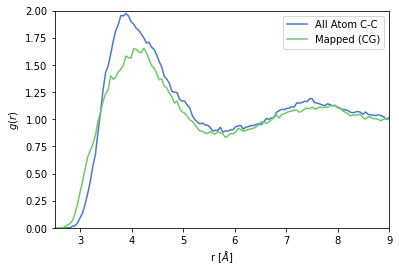

In [5]:
## Plot RDFs between Mapped CG beads (center of masses) and the reference (C-O in all atom system )

matplotlib.style.use('seaborn-muted')
plt.plot(train_vars['rdf-r'],train_vars['avg-aa-rdf']/ train_vars['avg-aa-rdf'][-1],label ='All Atom C-C')
plt.plot(train_vars['rdf-r'], train_vars['avg-rdf'] / train_vars['avg-rdf'][-1], label='Mapped (CG)')
plt.xlim(2.5,9)
plt.ylim(0,2)
plt.xlabel(r'r [$\AA$]')
plt.ylabel('$g(r)$')
plt.legend()
plt.show()